In [1]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")

In [3]:
hm_w = 12
hm_h = 4
title = False
sns.set(font_scale = 1.8)

# Reordering

In [4]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total,
        median(reorder) as reorder,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results/reorder.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
reorder_df = con.fetchdf()
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,2.051544e+10
1,row,2.792118e+10


In [5]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        -- cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        reorder_df r,
        reorder_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
reorder_total_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from reorder_total_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,0.426563,0.4


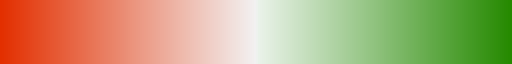

In [6]:
my_cmap = sns.diverging_palette(15, 125, s=100, l=50, as_cmap=True)
my_cmap

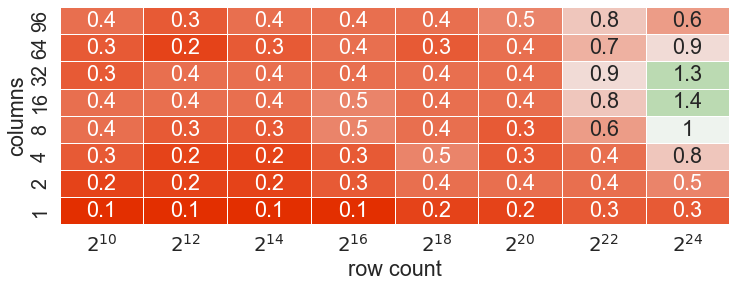

In [7]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(reorder_total_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
if title:
    plt.title('Relative speedup of payload re-ordering rows vs. columns')
plt.savefig('figures/reorder_sg.eps', bbox_inches="tight")
plt.show()

In [8]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.reorder as "row reorder",
        c.reorder as "col reorder",
        -- cast (case when c.reorder > r.reorder then c.reorder / r.reorder - 0.95 else -(r.reorder / c.reorder - 0.95) end as decimal(10,1)) as speedup
        cast(c.reorder / r.reorder + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.reorder > r.reorder then c.reorder / r.reorder else -(r.reorder / c.reorder) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.reorder > r.reorder then 1 else -1 end as binary_speedup
    from
        reorder_df r,
        reorder_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
reorder_only_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from reorder_only_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,1.317187,1.2


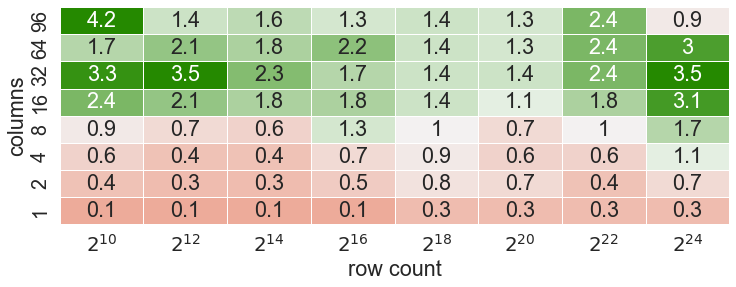

In [9]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(reorder_only_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
if title:
    plt.title('Relative speedup of JUST re-ordering rows vs. columns (excl. scatter + gather)')
plt.savefig('figures/reorder_naked.eps', bbox_inches="tight")
plt.show()

In [10]:
con.execute("""
    select
        cast(log2(count) as int) as "row count",
        columns,
        col_width,
        reorder as "row reorder",
        cast(cast(scatter + gather as double) / total as decimal(10,2)) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        "row count" asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.546094,0.57


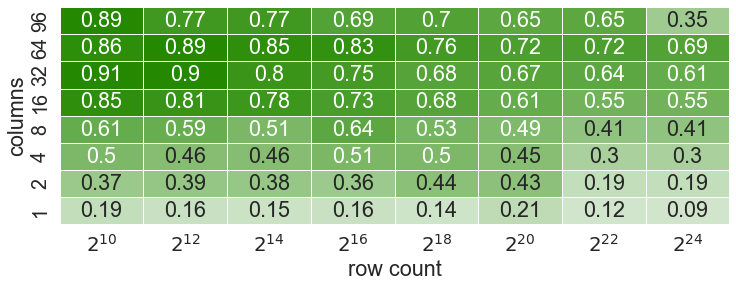

In [11]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(reorder_percentage_df.pivot('columns', 'row count', 'sg'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
if title:
    plt.title('Time spent on scatter + gather when re-ordering rows')
plt.show()

# Comparator

In [12]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total,
        median(sort) as sort,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results/comparator.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
comparator_df = con.fetchdf()
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,4.027084e+10
1,row_branched,1.463618e+10
2,row_branchless,8.541068e+09


In [13]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        -- cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branched'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
col_row_comparator_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from col_row_comparator_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,1.634375,1.4


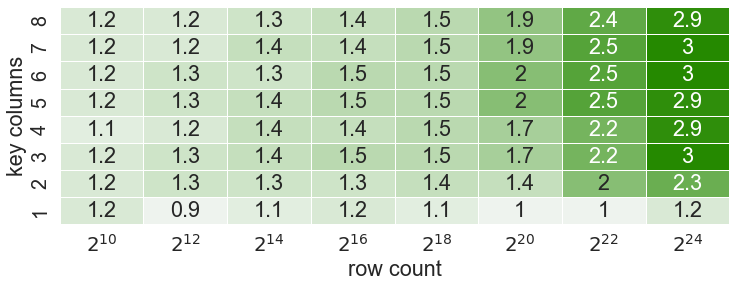

In [14]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(col_row_comparator_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_ylabel('key columns')
if title:
    plt.title('Relative speedup of row keys vs. columnar (pdqsort)')
plt.savefig('figures/comparator_row_col.eps', bbox_inches="tight")
plt.show()

In [15]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        -- cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branchless'
    and c.category = 'row_branched'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
col_nk_comparator_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from col_nk_comparator_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,1.676562,1.7


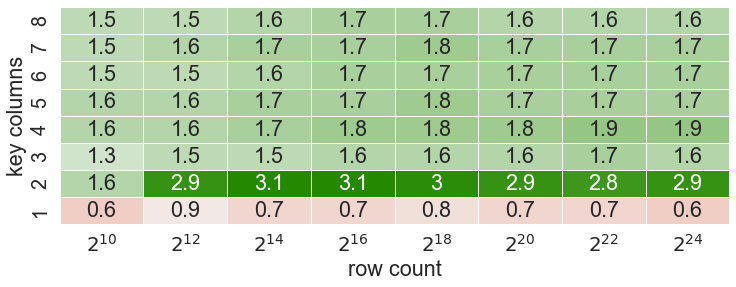

In [16]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(col_nk_comparator_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_ylabel('key columns')
if title:
    plt.title('Relative speedup of normalized keys vs. row keys (pdqsort)')
plt.savefig('figures/comparator_nk_row.eps', bbox_inches="tight")
plt.show()

In [17]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        -- cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.reorder then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branchless'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
comparator_only_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from comparator_only_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,3.15625,2.7


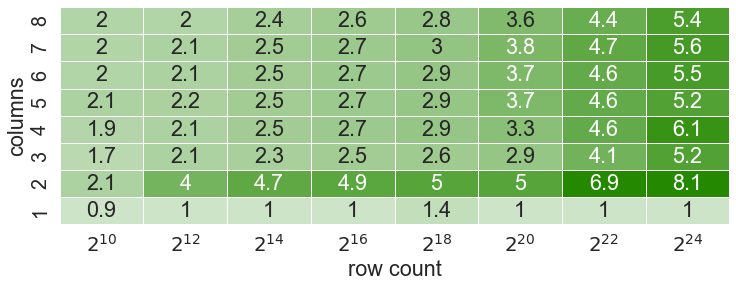

In [18]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(comparator_only_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
if title:
    plt.title('Relative speedup of JUST sorting binary string encoding vs. columns (excl. scatter + gather)')
plt.show()

# Sort

In [26]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total,
        median(sort) as sort,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results/sort.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
sort_df = con.fetchdf()
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_dynamic,1.173192e+10
1,pdq_static,7.668559e+09
2,radix,1.071281e+10


In [27]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        -- cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        sort_df r,
        sort_df c
    where
        r.category = 'radix'
    and c.category = 'pdq_static'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
sort_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from sort_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,0.585938,0.6


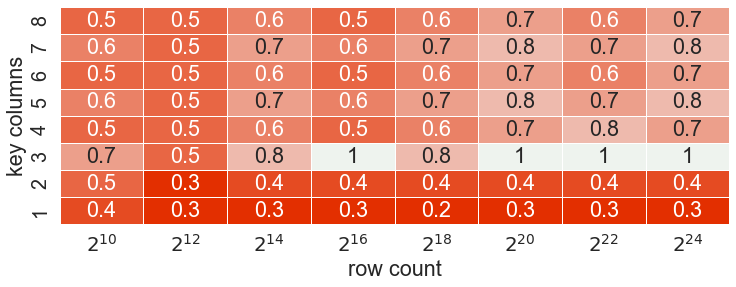

In [28]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(sort_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_ylabel('key columns')
if title:
    plt.title('Relative speedup of radix sort vs. static pdqsort')
plt.savefig('figures/sort_static.eps', bbox_inches="tight")
plt.show()

In [29]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        -- cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        sort_df r,
        sort_df c
    where
        r.category = 'radix'
    and c.category = 'pdq_dynamic'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
sort_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from sort_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,1.14375,0.85


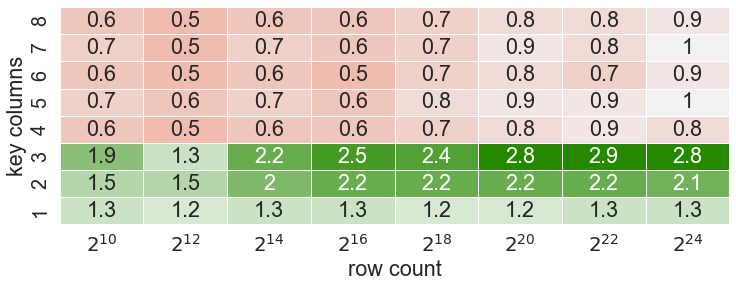

In [30]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(sort_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_ylabel('key columns')
if title:
    plt.title('Relative speedup of radix sort vs. dynamic pdqsort')
plt.savefig('figures/sort_dynamic.eps', bbox_inches="tight")
plt.show()

# Merge

In [24]:
con = duckdb.connect()
con.execute("""
    with sg as (
        select
            category,
            count,
            columns,
            col_width,
            median(scatter) as scatter,
            median(gather) as gather
        from
            read_csv_auto('results/reorder.csv')
        group by
            category,
            count,
            columns,
            col_width
    )
    select
        m.category,
        m.count,
        m.columns,
        m.col_width,
        median(m.total) as merge,
        median(m.total + sg.scatter + sg.gather) as total
    from
        read_csv_auto('results/merge.csv') as m,
        sg
    where
        m.category = sg.category
    and m.count = sg.count
    and m.columns = sg.columns
    and m.col_width = sg.col_width
    group by
        m.category,
        m.count,
        m.columns,
        m.col_width
    order by
        m.count,
        m.columns,
        m.col_width,
        m.category
""")
merge_df = con.fetchdf()
con.execute("select category, sum(total) from merge_df group by category")
con.fetchdf()

,category,sum(total)
0,col,8.309234e+09
1,row,1.961736e+10


In [25]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.merge as "row merge",
        c.merge as "col merge",
        -- cast (case when c.merge > r.merge then c.merge / r.merge - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        merge_df r,
        merge_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
merge_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from merge_speedup_df")
con.fetchdf()

RuntimeError: Binder Error: Table "c" does not have a column named "sort"
LINE 9:         cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        merge_df r,
        merge_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
...
                     ^

In [ ]:
fig, ax = plt.subplots(figsize=(hm_w, hm_h))
g = sns.heatmap(merge_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
if title:
    plt.title('Relative speedup of merging rows vs. columns')
plt.savefig('figures/merge.eps', bbox_inches="tight")
plt.show()

# Trace

In [ ]:
con = duckdb.connect()
con.execute("""
    select
        sim,
        category,
        count,
        columns,
        median(L2_TLB_MISS_DATA) as l2_tlb_miss,
        median(L1D_CACHE_MISS_LD) + median(L1D_CACHE_MISS_ST) as l1_cache_miss,
        median(L1D_TLB_MISS) as l1_tlb_miss
    from
        read_csv_auto('results/trace.csv')
    group by
        sim,
        category,
        count,
        columns
    order by
        sim,
        count,
        columns,
        category
""")
trace_df = con.fetchdf()
trace_df.head()

In [ ]:
con.execute("""
    select
        r.sim,
        r.count as "row count",
        r.columns,
        r.l1_cache_miss as "row l1 cache miss",
        c.l1_cache_miss as "col l1 cache miss",
        cast(case when c.l1_cache_miss > r.l1_cache_miss then -(c.l1_cache_miss / r.l1_cache_miss - 0.95) else (r.l1_cache_miss / c.l1_cache_miss - 0.95) end as decimal(10,1)) as "cache miss change"
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        trace_df r,
        trace_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.sim = c.sim
    and r.count == c.count
    and r.columns == c.columns
    order by
        "row count" asc,
        columns asc
""")
cache_miss_df = con.fetchdf()
con.execute('select avg("cache miss change"), median("cache miss change") from cache_miss_df')
con.fetchdf()

In [ ]:
con.execute("select * from cache_miss_df where sim = 'comparator'")
comparator_df = con.fetchdf()

con.execute("select * from cache_miss_df where sim = 'sort'")
sort_df = con.fetchdf()

con.execute("select * from cache_miss_df where sim = 'reorder'")
reorder_df = con.fetchdf()

con.execute("select * from cache_miss_df where sim = 'merge'")
merge_df = con.fetchdf()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4.5))
g = sns.heatmap(comparator_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses comparator rows vs. columns')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4.5))
g = sns.heatmap(sort_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses radix sort vs. std::sort')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4.5))
g = sns.heatmap(reorder_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses reorder rows vs. columns')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4.5))
g = sns.heatmap(merge_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses merge rows vs. columns')
plt.show()

In [ ]:
for i in range(2, 20):
    print('struct NormalizedKey' + str(i * 4) + ' {')
    for j in range(i):
        print('\tuint32_t i' + str(j) + ';')
    print('};\n')

In [ ]:
print('void PDQSort(data_ptr_t ptr, idx_t count, idx_t row_width, idx_t comp_width) {')
print('\tswitch (row_width) {')
for i in range(2, 20):
    print(f'\tcase {i * 4}:')
    print(f'\t\treturn PDQSort<NormalizedKey{i * 4}>(ptr, count, comp_width);')
print('\t}')
print('}')

In [ ]:
print('template <class T, idx_t col_offset>')
print('void PDQSortSwitchCompWidth(data_ptr_t ptr, idx_t count, idx_t comp_width) {')
print('\tswitch (comp_width) {')
for i in range(0, 37):
    print(f'\tcase {i}:')
    print(f'\t\treturn PDQSort<T, col_offset, {i}>(ptr, count);')
print('\t}')
print('}')

In [ ]:
print('template <class T>')
print('void PDQSortSwitchColOffset(data_ptr_t ptr, idx_t count, idx_t col_offset, idx_t comp_width) {')
print('\tswitch (col_offset) {')
for i in range(0, 36):
    print(f'\tcase {i}:')
    print(f'\t\treturn PDQSortSwitchCompWidth<T, {i}>(ptr, count, comp_width);')
print('\t}')
print('}')

In [ ]:
print('void PDQSortSwitchRowWidth(data_ptr_t ptr, idx_t count, idx_t row_width, idx_t col_offset, idx_t comp_width) {')
print('\tswitch (row_width) {')
for i in range(2, 9):
    print(f'\tcase {i * 4}:')
    print(f'\t\treturn PDQSortSwitchColOffset<NormalizedKey{i * 4}>(ptr, count, col_offset, comp_width);')
print('\t}')
print('}')

In [ ]:
n_structs = (64 - 16)/8
n_offsets = len(range(0, 60))
n_comp_widths = len(range(1, 61))
n_structs * n_offsets * n_comp_widths